In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(12345)



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/MS014_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,MS014-BT,0.0,0.00000,0.005000,0.000000,0.0,0.005000,0.0,0.0,0.000000
1,MS014-BT,12.0,0.00000,1.159119,0.000000,0.0,0.373214,0.0,0.0,0.000000
2,MS014-BT,24.0,0.00000,0.926596,0.000000,0.0,0.251904,0.0,0.0,0.000000
3,MS014-BT-BU-BV-CA,0.0,0.00200,0.002000,0.002000,0.0,0.002000,0.0,0.0,0.002000
4,MS014-BT-BU-BV-CA,12.0,0.00121,0.726282,0.144269,0.0,0.330583,0.0,0.0,0.083322


In [3]:
species = ['BT', 'BU']
BT_data = gLV_data.iloc[np.in1d(gLV_data.Treatments.values, [f"Monoculture{sp}" for sp in species])]
# species = ["CD"]
BT_data = BT_data[["Treatments", "Time"] + species]
BT_data

,Treatments,Time,BT,BU
171,MonocultureBT,0.0,0.022933,0.000000
172,MonocultureBT,3.0,0.172033,0.000000
173,MonocultureBT,6.0,0.470100,0.000000
174,MonocultureBT,9.0,0.811533,0.000000
175,MonocultureBT,12.0,0.703900,0.000000
176,MonocultureBT,15.0,0.628433,0.000000
177,MonocultureBT,18.0,0.621433,0.000000
178,MonocultureBT,21.0,0.624033,0.000000
179,MonocultureBT,24.0,0.658800,0.000000
180,MonocultureBT,27.0,0.706167,0.000000


# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def plot(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1], 100)
        steps = len(t_eval)
        output, stdv, COV = model.predict_latent(x_test, t_eval)
        # output = model.predict_point(x_test, t_eval)

        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out = output[:,i]
            out_true = output_true[:, i]
            if out[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i))
                plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                plt.fill_between(t_eval, out-stdv[:, i], out+stdv[:, i], color='C{}'.format(i), alpha=0.2)
                
        plt.xlabel("Time (hr)")
        plt.ylabel("Species abundance")
        #plt.legend(loc='upper left')
        plt.title(f"C-R+NN fit to monoculture")
        plt.savefig("figures/CRNN_mono_s.pdf")
        plt.show()
        
        # plot predictions of hidden variables
        for k in range(output.shape[-1] - (i+1)):
            plt.plot(t_eval, np.exp(output[:,i+1+k]), label=f"Predicted R{k+1}", color=f'C{k+1}')
            '''plt.fill_between(t_eval, 
                             np.exp(output[:,i+1+k] - stdv[:,i+1+k]), 
                             np.exp(output[:,i+1+k] + stdv[:,i+1+k]), 
                             color=f'C{k+1}', alpha=0.2)'''

        plt.legend()
        plt.ylabel("Resource concentration")
        plt.xlabel("Time (hr)")
        plt.savefig("figures/CRNN_mono_r.pdf")
        plt.show()
        
# function to predict from posterior samples
def predict_MC(self, x_test, t_eval, n_samples=300):

    # monte carlo draws from posterior
    L = np.linalg.cholesky(self.Ainv)
    Z = np.random.randn(n_samples, self.n_params)
    posterior_params = self.params + np.einsum('jk,ik->ij', L, Z)

    # make point predictions of shape [n_mcmc, n_samples, n_time, n_outputs]
    preds = vmap(lambda params: jnp.nan_to_num(self.runODE(t_eval, x_test, params[:self.n_r], params[self.n_r:])), (0,))(posterior_params)

    return preds
        
# Define function to make Monte Carlo predictions on test data
def plot_MC(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1])
        output_MC = predict_MC(model, x_test, t_eval) 
        
        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out_true = output_true[:, i]
            if out_true[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i), edgecolor='k', zorder=2)
        
        for output_draw in output_MC:
            # plot the results
            for i in range(len(species)):
                out = output_draw[:,i]
                if out[0] > 0:
                    plt.plot(t_eval, out, color='C{}'.format(i), alpha=.1, zorder=1)
                
        plt.xlabel("Time (hr)")
        plt.ylabel("Species abundance")
        #plt.legend(loc='upper left')
        plt.title(f"C-R+NN fit to monoculture")
        # plt.savefig("figures/CRNN_mono_s.pdf")
        plt.show()
        
        # plot predictions of hidden variables
        for output in output_MC:
            for k in range(output.shape[-1] - (i+1)):
                plt.plot(t_eval, np.exp(output[:,i+1+k]), color=f'C{k+1}', alpha=.1, zorder=1)

        #plt.legend()
        plt.ylabel("Resource concentration")
        plt.xlabel("Time (hr)")
        # plt.savefig("figures/CRNN_mono_r.pdf")
        plt.show()

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2
n_x = n_r + n_s # + 1

# dimension of hidden layer
n_h = 4

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# log of death rate 
d = -3*np.ones(n_s)

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)

# maximum consumption rate parameters
C = -np.ones([n_r, n_s]) 
# # species with diauxic shift likely consume two resources
C[1:,:2] = -2.
# C[2:,:2] = -5. 
# # set prior s.t. monophasic growth curves are assumed to have one primary resource
# C[1:,2:] = -5.

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_r+n_s, n_h) 
b2 = np.random.randn(n_r+n_s)

# concatenate parameter initial guess
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten(), b2.flatten()))

# set prior so that C is sparse 
W1prior = np.zeros_like(W1)
b1prior = np.zeros_like(b1)
Cprior = -5*np.ones([n_r, n_s]) 
W2prior = np.zeros_like(W2)
b2prior = np.zeros_like(b2)

# concatenate prior 
prior = np.concatenate((d, W1prior.flatten(), b1prior, Cprior.flatten(), W2prior.flatten(), b2prior.flatten()))

n_params = len(params)
n_params

46

In [6]:
C.T

array([[-1., -2.],
       [-1., -2.]])

# Define model

In [7]:
# only allow consumption of one resource at a time 
mask = vmap(lambda v: v*jnp.array(v == jnp.max(v), float), (1), (1))

# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state 
    state = jnp.concatenate((s, r))
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jnp.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jnp.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # attractiveness of resource i to species j / consumption efficiency
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h], [n_r+n_s, n_h])
    b2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h:], [n_r+n_s])
    f  = jax.nn.sigmoid(jnp.einsum("jk,k->j", W2, h) + b2)
    
    # update Consumption matrix according to resource attractiveness 
    C = jnp.einsum("i,ij->ij", f[:n_r], Cmax)
    
    # rate of change of species 
    dsdt = s*f[n_r:]*(C.T@r - d)

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

# Fit model to mono culture data

In [9]:
r0 = np.random.uniform(-2, 0, n_r)
r0 = np.sort(r0)[::-1]
print(r0)

model = ODE(system = system, 
            dataframe=BT_data,
            C=O,
            CRparams = params, 
            r0 = r0,
            prior = prior,
            species = species,
            alpha_0=1e-5,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, patience=3, max_fails=2)
print("Elapsed time {:.2f}s".format(time.time()-t0))

[-1.02074659 -1.24531009]
Updating precision...
Total samples: 88, Updated regularization: 1.00e-05
Total weighted fitting error: 4.177
Total weighted fitting error: 1.165
Total weighted fitting error: 0.440
Total weighted fitting error: 0.268
Total weighted fitting error: 0.217
Total weighted fitting error: 0.142
Total weighted fitting error: 0.100
Total weighted fitting error: 0.082
Total weighted fitting error: 0.074
Total weighted fitting error: 0.074
Total weighted fitting error: 0.073
Total weighted fitting error: 0.072
Total weighted fitting error: 0.071
Total weighted fitting error: 0.071
Total weighted fitting error: 0.070
Total weighted fitting error: 0.070
Total weighted fitting error: 0.069
Total weighted fitting error: 0.069
Total weighted fitting error: 0.069
Total weighted fitting error: 0.068
Total weighted fitting error: 0.067
Total weighted fitting error: 0.066
Total weighted fitting error: 0.066
Total weighted fitting error: 0.065
Total weighted fitting error: 0.064


Total weighted fitting error: 10.753
Total weighted fitting error: 10.711
Total weighted fitting error: 10.705
Total weighted fitting error: 10.151
Total weighted fitting error: 10.099
Total weighted fitting error: 10.080
Total weighted fitting error: 9.352
Total weighted fitting error: 9.229
Total weighted fitting error: 9.218
Total weighted fitting error: 8.312
Total weighted fitting error: 8.123
Total weighted fitting error: 8.103
Total weighted fitting error: 7.286
Total weighted fitting error: 7.279
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 7.279123362865791
       x: [ 8.710e-01  8.290e-01 ... -6.594e-01 -8.982e-02]
     nit: 27
     jac: [ 2.221e+01 -2.296e+02 ...  4.572e+00  2.723e+01]
    nfev: 53
    njev: 53
    nhev: 27
Covariance not positive definite, increasing regularization...
Covariance not positive definite, increasing regularization...
Covariance not positive definite, increasing regularization...
Covariance not positive de

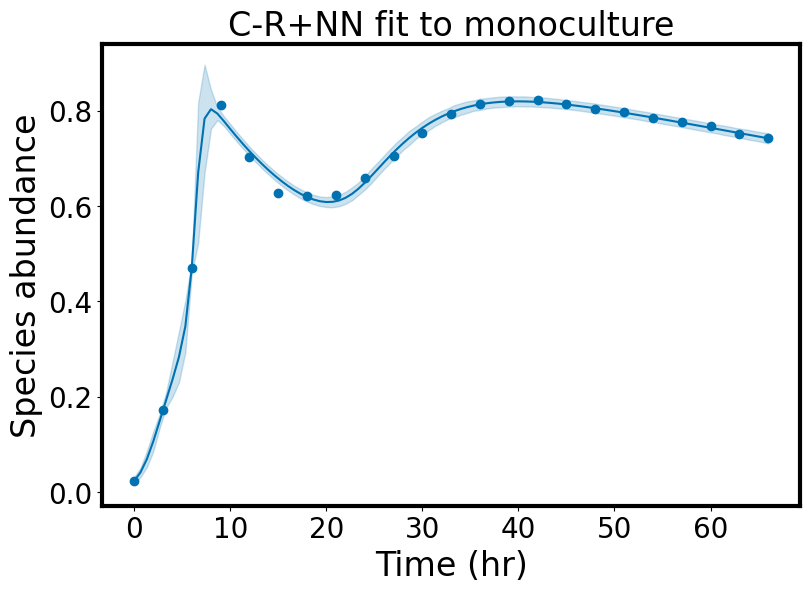

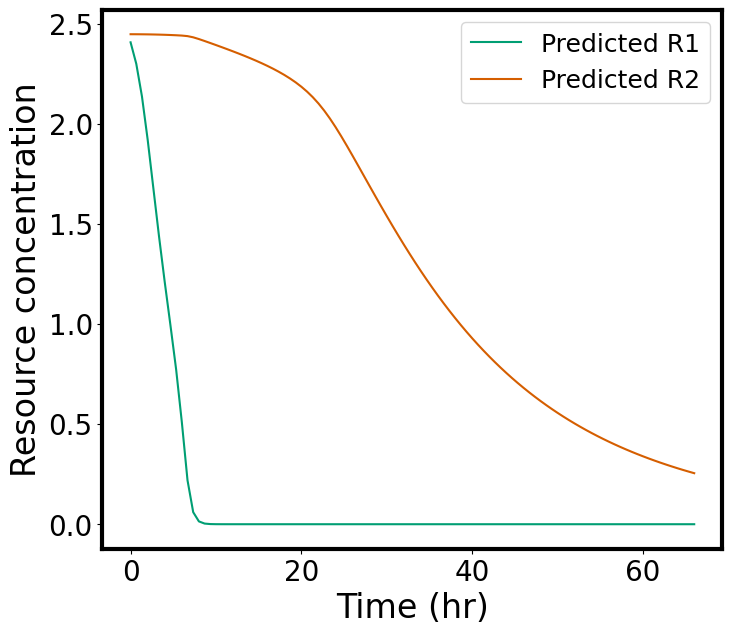

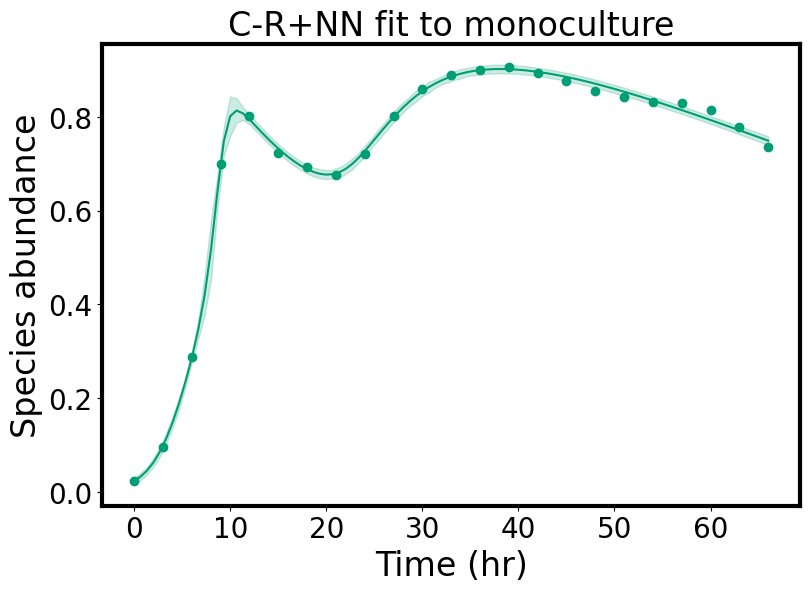

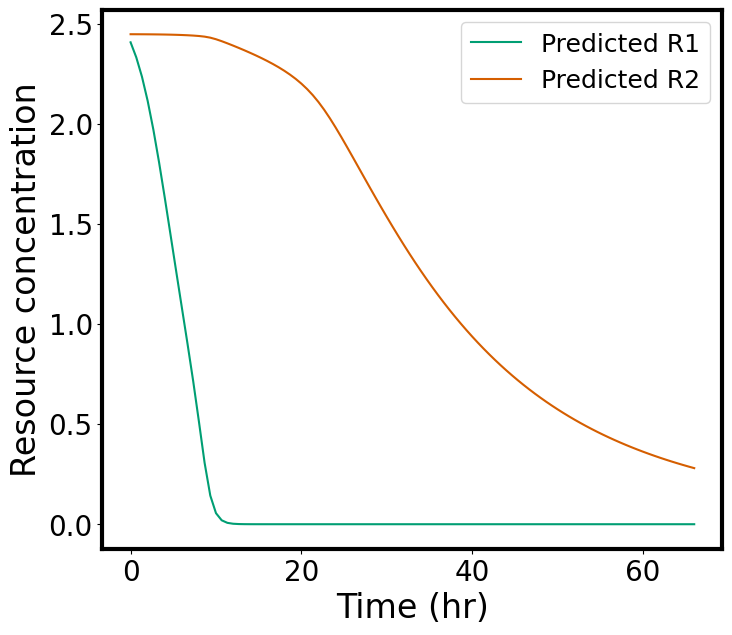

In [10]:
plot(model, BT_data)

In [11]:
r0 = model.params[:n_r]
r0

array([0.87893904, 0.89560558])

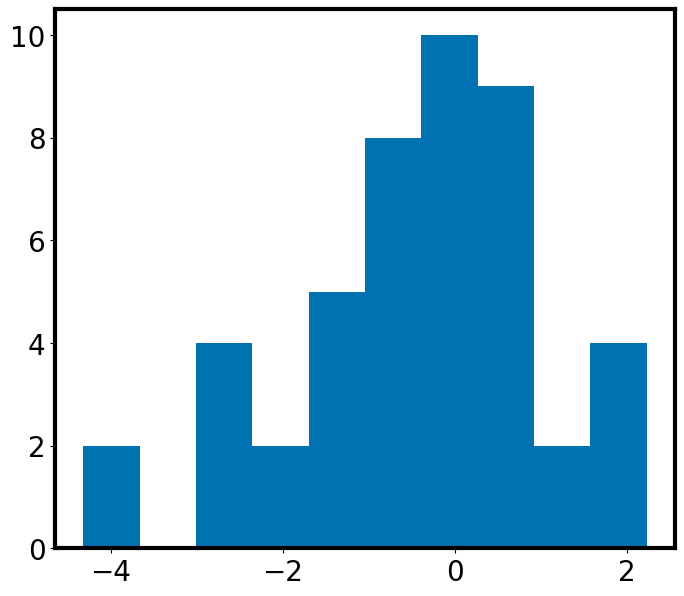

In [12]:
params = model.params[n_r:]
plt.hist(params)
plt.show()

In [13]:
# death rate
d = params[:n_s]
d

array([-2.83101147, -2.86158475])

In [14]:
# Cmax 
Cmax = np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s])
Cmax

array([[ 1.52595738,  1.27518347],
       [-2.7567956 , -2.88712515]])

In [15]:
model.N

44.0